I counted short/long reads that mapped to differentially spliced exons. <br>
Sequence: JoNe SF3B1 K700E, hg38 Splicemap/BLAT-aligned. <br>
Exons: Table S2 from <a href=http://www.cell.com/cancer-cell/fulltext/S1535-6108(16)30492-5>Wang et al.</a> <br>
Made them into a bed file and used liftOver to change the coordinates to hg38.


[1] 276

,short,long
PCK2,236,4
"GOLGA6L5,RP11-182J1.12",0,0
DDHD2,1,0
DYNLL1,31,6
HECTD4,1,0
PDCD2,219,3


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"83 x values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"90 y values <= 0 omitted from logarithmic plot"

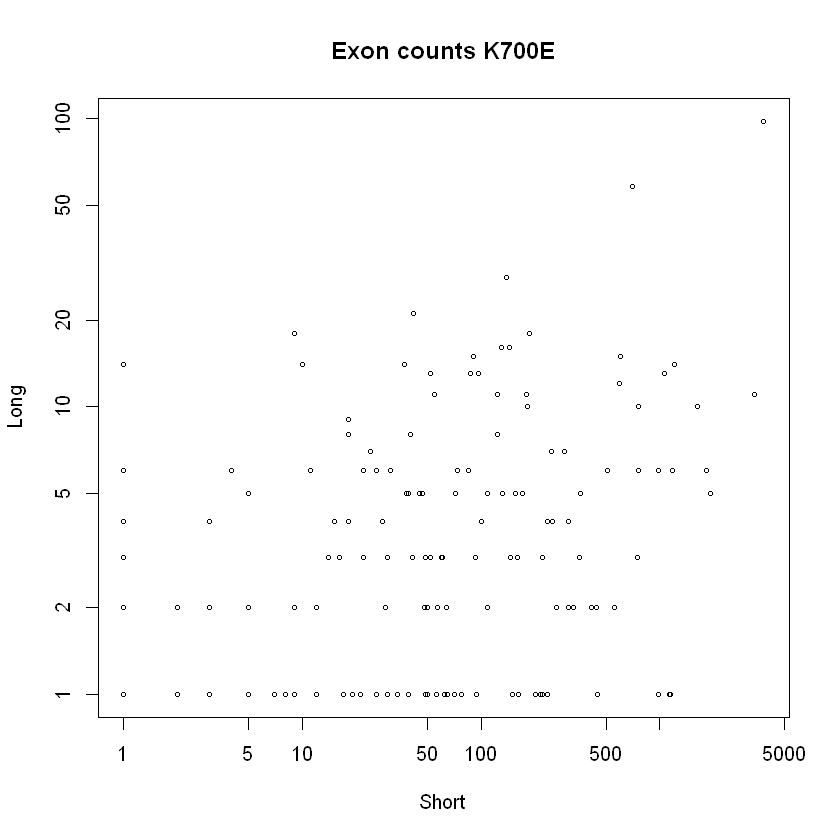

In [21]:
setwd('~/bme')
short = read.table('shortread_junction_support_exon.txt', fill=T)
long = read.table('longread_junction_support_exon.txt', fill=T)
df = data.frame(short=short$V2, long=long$V2, row.names=short$V1)
nrow(df)  # printed: total number differentially spliced genes
head(df)
plot(df$short, df$long, xlab='Short', ylab='Long', cex=0.5, log='xy', main='Exon counts K700E')  # log base 10

I ran kallisto for transcript-level quantification of the JoNe short reads. I ran <a href='https://vollmerslab.soe.ucsc.edu/software'>Mandalorion</a> to quantify expression of ONT reads. Mandalorion provided gene counts and found isoform expression levels, however the isoforms were not named using an annotation file but instead were defined by the program (e.g. each gene would have isoform1, isoform2, and so on but the isoforms would not be named or identified). Chris said he made this decision because he observed that the majority of the time, the nanopore reads did not produce isoforms that matched the annotation. <br> <br> Below is my plot of gene expression comparing Illumina to ONT.

In [1]:
setwd('~/bme')
short = read.table('abundance.r.txt')
long = read.table('Gene_Expression.r.txt')
short$V2 = as.character(short$V2)  # ensembl gene names
short$V3 = as.character(short$V3)  # hugo gene symbols
short$V5 = as.numeric(short$V5)  # est_counts
long$V1 = as.character(long$V1)
long$V2 = as.numeric(long$V2)
relevant_genes = c(short$V2[short$V5 != 0], long$V1[!long$V1 %in% short$V2 & long$V2 != 0])  # genes expressed in at least one
# of the datasets. Used to order all the genes
short_normalized = short$V5 / short$V7  # dividing by effective length, took a weighted average of effective transcript lengths
short_counts = short_normalized[match(relevant_genes, short$V2)]
short_tpm = short$V6[match(relevant_genes, short$V2)]
long_counts = long$V2[match(relevant_genes, long$V1)]
sum(is.na(short_counts))  # printed: number of genes found to be expressed in the long reads but not in the short reads
sum(is.na(long_counts))  # printed: vice versa
short_counts[is.na(short_counts)] = 0
short_tpm[is.na(short_tpm)]=0
long_counts[is.na(long_counts)] = 0
df = data.frame(short=short_counts, long=long_counts)
df_both_expressed = df[df$short != 0 & df$long != 0,]
cor(df_both_expressed$short, df_both_expressed$long)  # printed: pearson
cor(short_counts, long_counts)  # printed, 0s included in the vectors

altsplice_names = unique(as.character(read.table('junction_counts_short.txt')$V1))  # for the colored points
altsplice_gene_names_ensembl = short$V2[short$V3 %in% altsplice_names]
short_counts_altsplicegenesonly = short_counts[relevant_genes %in% altsplice_gene_names_ensembl]
long_counts_altsplicegenesonly = long_counts[relevant_genes %in% altsplice_gene_names_ensembl]

[1] 673

[1] 2197

[1] 0.3163611

[1] 0.1730061

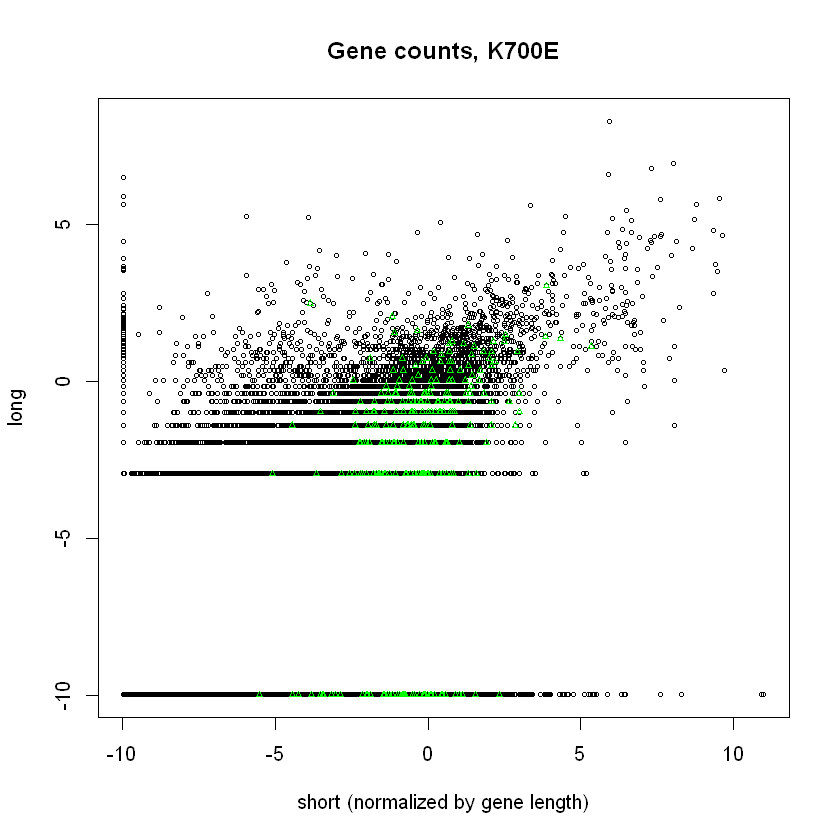

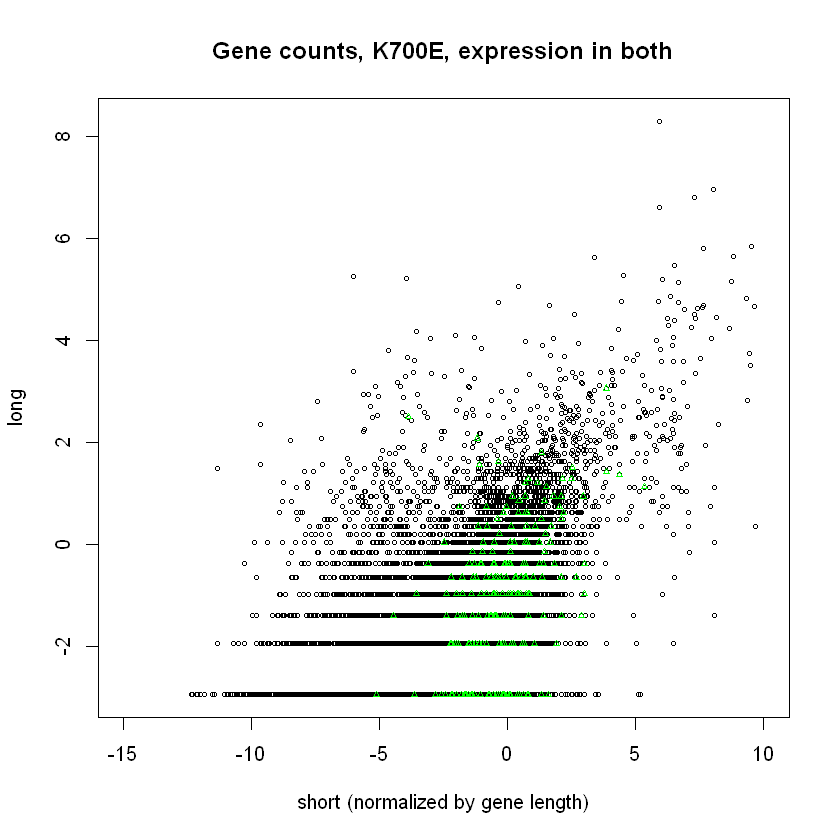

In [2]:
plot(log2(short_counts+0.001), log2(long_counts+0.001), xlab='short (normalized by gene length)', ylab='long',
     cex=0.5, main='Gene counts, K700E')  # data are log2 transformed, short read counts are normalized by gene length
points(log2(short_counts_altsplicegenesonly+0.001), log2(long_counts_altsplicegenesonly+0.001), col='green',
     cex=0.5, pch=24)  # coloring the points for the alternatively spliced genes in the mmc3 file
plot(log2(df_both_expressed$short), log2(df_both_expressed$long), xlab='short (normalized by gene length)', ylab='long',
     cex=0.5, main='Gene counts, K700E, expression in both', xlim=c(-15, 10))  # data are log2 transformed, no zeros in data so no 0.001 added
points(log2(short_counts_altsplicegenesonly), log2(long_counts_altsplicegenesonly), col='green',
     cex=0.5, pch=24)  # coloring the points for the alternatively spliced genes in the mmc3 file

In the Figure 4C of the <a href=https://www.nature.com/articles/srep31602#f4>Oikonomopolous benchmark paper</a>, they got a Pearson r of 0.75 for the correlation of their short reads in TPM with their number of minION reads. I tried using TPM instead of counts divided by gene length, which is what I was doing previously. The TPM values are from kallisto and summed up to a gene level to match the gene-level counts for the long reads from Mandalorion. The resulting Pearson is slightly worse (comparing 0.316 to 0.194).

[1] 0.1944389

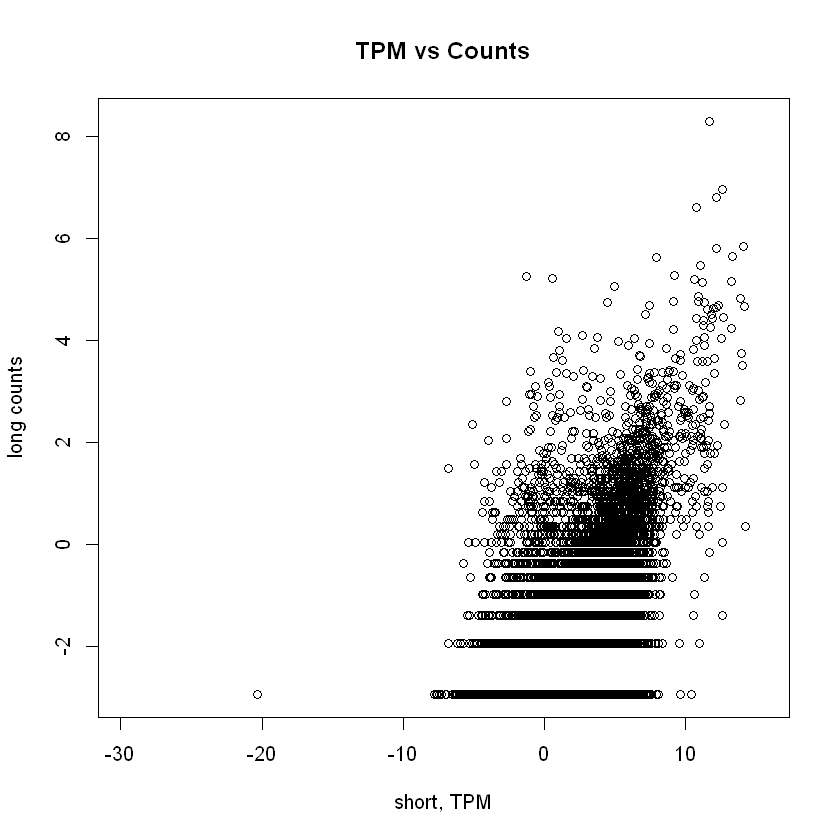

In [13]:
plot(log2(short_tpm), log2(long_counts), main='TPM vs Counts', xlab='short, TPM', ylab='long counts')
cor(short_tpm, long_counts)

The exon sequences from TableS2 are the output of JuncBASE, and there is ambiguity in junction support because 1) a read mapping to the exon is not necessarily a junction read and 2) non-junction reads are not informative in determining the true junction. To address this, short and long reads spanning the alternative junctions were quantified instead. Long reads were counted as supported a junction if there was sequence on either end of the junction with a 5, 6, 7, or 8 basepair window around each of the splice sites. 
<br>
The following plot is for a 5 basepair window.

V1,V2,V3,V4
PCK2,24099721,24099994,0
PCK2,24099721,24102752,0
"GOLGA6L5,RP11-182J1.12",84513303,84513966,0
"GOLGA6L5,RP11-182J1.12",84513331,84513966,0
DDHD2,38237628,38238106,19
DDHD2,38237628,38238088,29


[1] 0.05141375

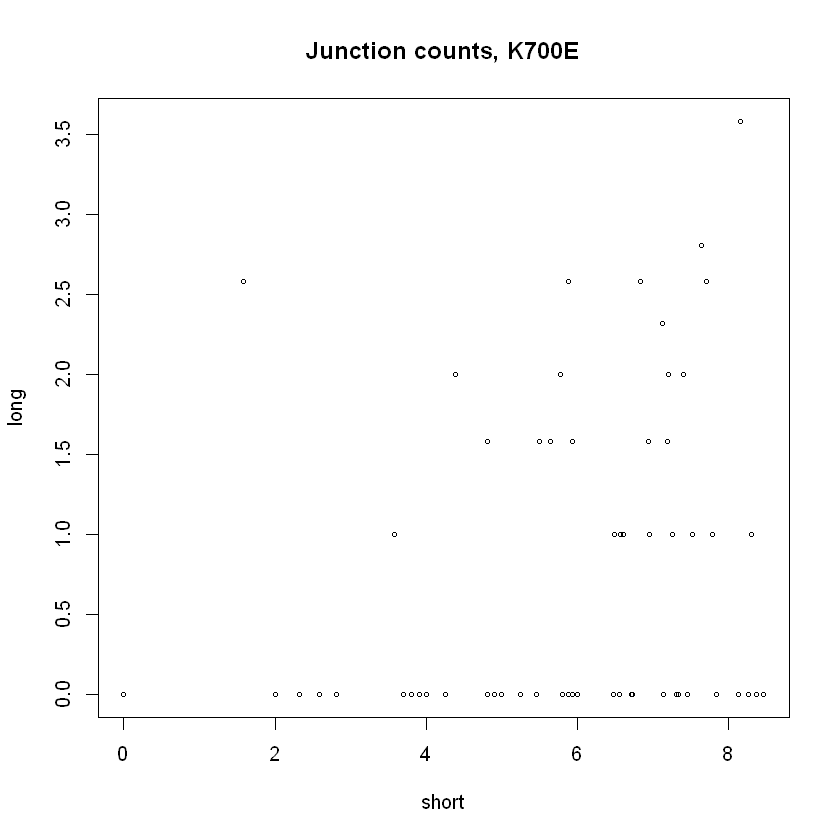

In [26]:
setwd('~/bme')
short = read.table('junction_counts_short.txt')
long = read.table('junction_counts_long.txt')
head(short)  # V1=gene name, V2 and V3=junction coordinates, V4=counts
short$V5 = paste0(short$V1, short$V2, short$V3)
long$V5 = paste0(long$V1, long$V2, long$V3)
com = data.frame(s=short$V4, l=long$V4)
com = com[com$s != 0 & com$l != 0,]
cor(short$V4, long$V4)
plot(log2(com$s), log2(com$l), cex=0.5, xlab='short', ylab='long', main='Junction counts, K700E')

The problem is not in how the splice sites counts are being quantified, see below 4 plots. First, relaxing the splice window the long reads had to align to from 5 to 8 basepairs on either side provided slightly worse data, based solely on correlations. I tried 20 basepairs of wiggle room (40 bp window total!) and the plot still looked similar. Also, a few splice site counts in for the short reads and the long reads were verified manually in IGV/the browser and looked good. Since the counting seems to be good enough, the poor correlation could be attributed to large variability in transcripts sequenced in the nanopore...

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"521 x values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"520 y values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"521 x values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"518 y values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"521 x values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"515 y values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"521 x values <= 0 omitted from logarithmic plot"Warning message in xy.coords(x, y, xlabel, ylabel, log):
"480 y values <= 0 omitted from logarithmic plot"

[1] 0.05141375

[1] 0.05026121

[1] 0.05162099

[1] 0.05016083

[1] 0.04729071

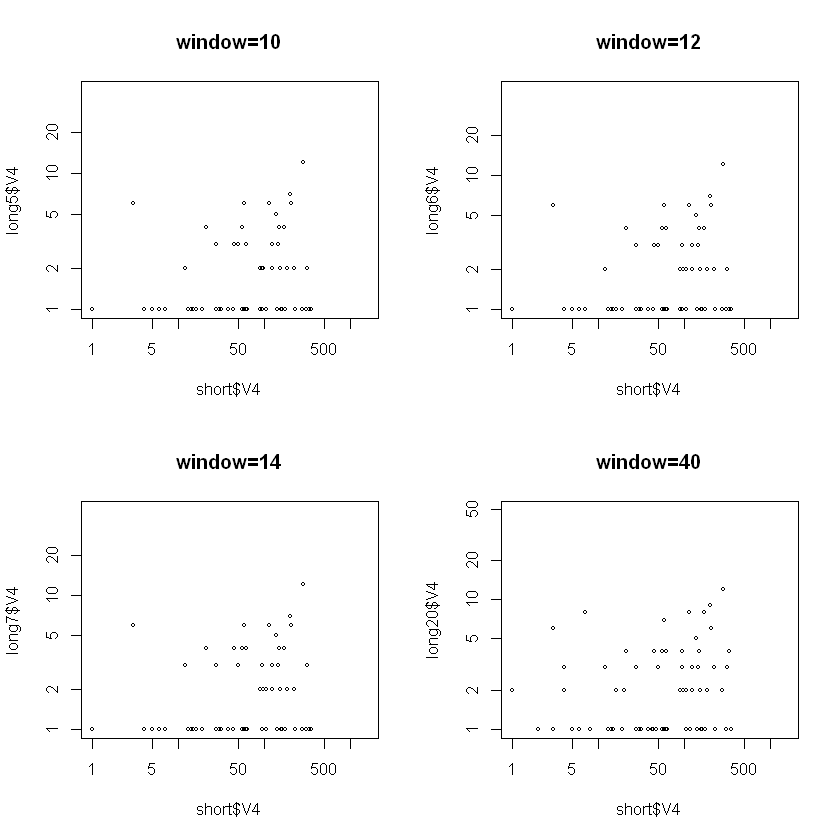

In [16]:
setwd('~/bme')
attach(mtcars)
par(mfrow=c(2,2))
long5 = read.table('junction_counts_long.txt')  # all counts are for the mutant SF3B1 sample
long6 = read.table('junction_counts_long.6.txt')
long7 = read.table('junction_counts_long.7.txt')
long8 = read.table('junction_counts_long.8.txt')
long20 = read.table('junction_counts_long.20.txt')
short = read.table('junction_counts_short.txt')
plot(short$V4, long5$V4, cex=0.5, log='xy', main='window=10')  # log base 10
plot(short$V4, long6$V4, cex=0.5, log='xy', main='window=12')
plot(short$V4, long7$V4, cex=0.5, log='xy', main='window=14')
plot(short$V4, long20$V4, cex=0.5, log='xy', main='window=40')
cor(short$V4, long5$V4)
cor(short$V4, long6$V4)
cor(short$V4, long7$V4)
cor(short$V4, long8$V4)
cor(short$V4, long20$V4)

I then repeated the same analysis but with the wildtype SF3B1 long/short reads. 
First is the gene plot, then the junction plot.

In [5]:
setwd('~/bme')
short = read.table('abundance.r.wt.txt')
long = read.table('Gene_Expression.r.wt.txt')
short$V2 = as.character(short$V2)  # ensembl gene names
short$V3 = as.character(short$V3)  # hugo gene symbols
short$V5 = as.numeric(short$V5)  # est_counts
long$V1 = as.character(long$V1)
long$V2 = as.numeric(long$V2)
relevant_genes = c(short$V2[short$V5 != 0], long$V1[!long$V1 %in% short$V2 & long$V2 != 0])  # genes expressed in at least one
# of the datasets. Used to order all the genes
short_normalized = short$V5 / short$V7  # dividing by effective length, took a weighted average of effective transcript lengths
short_counts = short_normalized[match(relevant_genes, short$V2)]
long_counts = long$V2[match(relevant_genes, long$V1)]
sum(is.na(short_counts))  # printed: number of genes found to be expressed in the long reads but not in the short reads
sum(is.na(long_counts))  # printed: vice versa
short_counts[is.na(short_counts)] = 0
long_counts[is.na(long_counts)] = 0
df = data.frame(short=short_counts, long=long_counts)
df_both_expressed = df[df$short != 0 & df$long != 0,]
cor(df_both_expressed$short, df_both_expressed$long)  # printed: spearman, rank-based
cor(short_counts, long_counts)  # printed, 0s included in the vectors

altsplice_names = unique(as.character(read.table('junction_counts_short.txt')$V1))  # for the colored points
altsplice_gene_names_ensembl = short$V2[short$V3 %in% altsplice_names]
short_counts_altsplicegenesonly = short_counts[relevant_genes %in% altsplice_gene_names_ensembl]
long_counts_altsplicegenesonly = long_counts[relevant_genes %in% altsplice_gene_names_ensembl]

[1] 430

[1] 2156

[1] 0.2485276

[1] 0.1224551

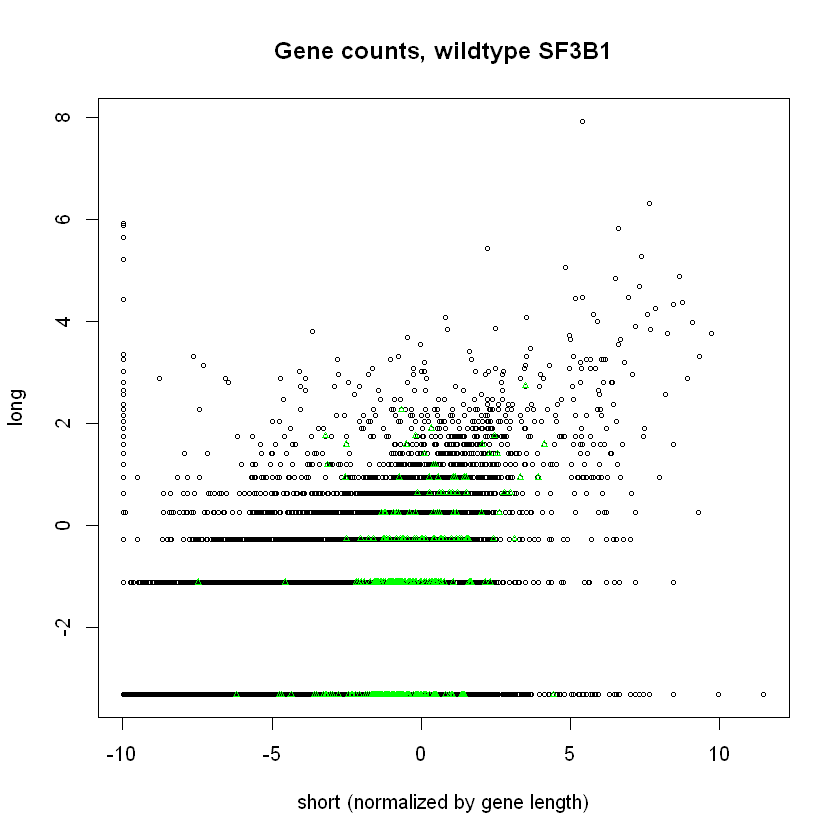

In [15]:
plot(log2(short_counts+0.001), log2(long_counts+0.1), xlab='short (normalized by gene length)', ylab='long',
     cex=0.5, main='Gene counts, wildtype SF3B1')  # data are log2 transformed, short read counts are normalized by gene length
points(log2(short_counts_altsplicegenesonly+0.001), log2(long_counts_altsplicegenesonly+0.1), col='green',
     cex=0.5, pch=24)  # coloring the points for the alternatively spliced genes in the mmc3 file

[1] 0.06502027

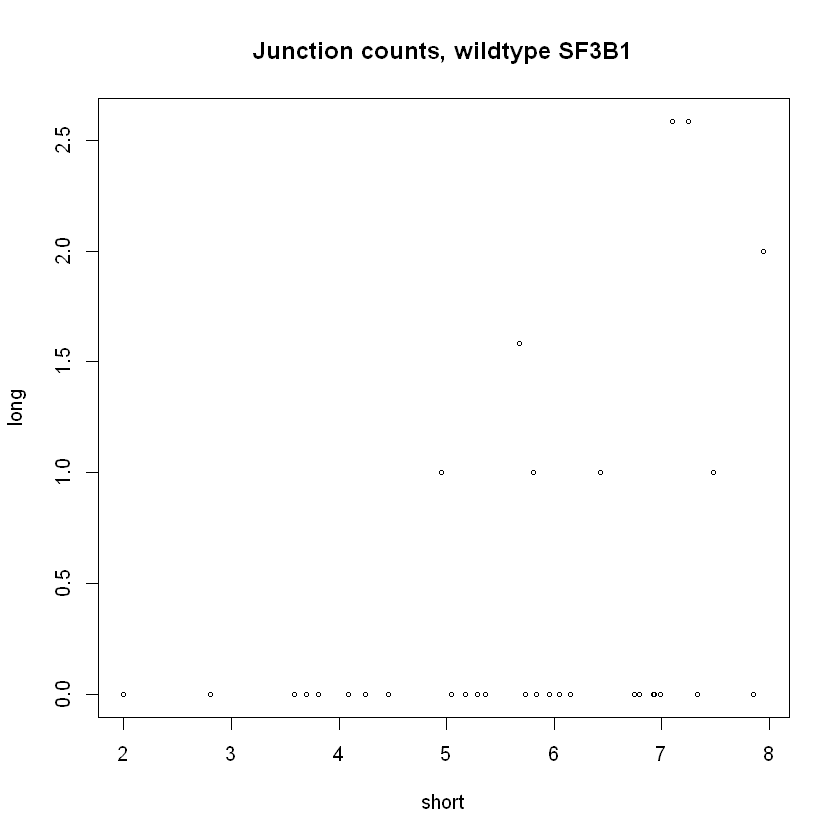

In [12]:
setwd('~/bme')
short = read.table('junction_counts_short.wt.txt')
long = read.table('junction_counts_long.wt.6.txt')
short$V5 = paste0(short$V1, short$V2, short$V3)
long$V5 = paste0(long$V1, long$V2, long$V3)
com = data.frame(s=short$V4, l=long$V4)
com = com[com$s != 0 & com$l != 0,]
cor(short$V4, long$V4)
plot(log2(com$s), log2(com$l), cex=0.5, xlab='short', ylab='long', main='Junction counts, wildtype SF3B1')

I just wanted to see how many junction reads we would need to for a Fisher's exact test to return a significant result. It's pretty rough, since it assumes you have the same number of junction reads found in both conditions.

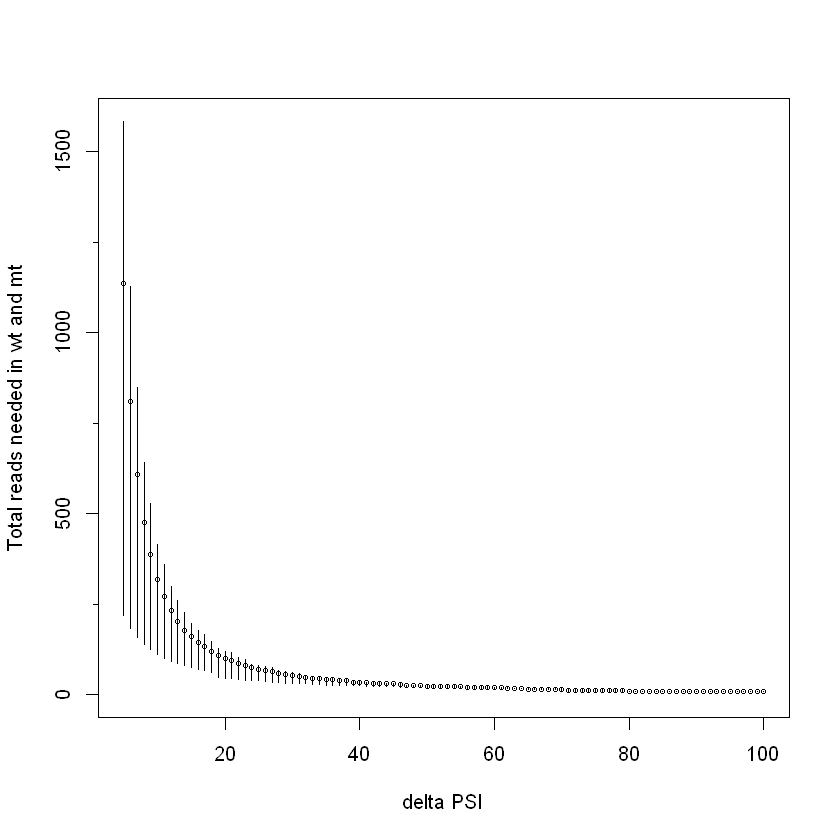

In [4]:
totalwt = totalmt = 4  # for now I always have the same number of reads in wild type and mutant
avg_reads = c()  # average number of reads needed in one sample
upper_reads = c()  # upper bound on number of reads
lower_reads = c()  
for (deltapsi in seq(100, 5)) {  # e.g. 30
    sample_diff_center = c()
    for (wtpsi in 0:(min(c(50, 100-deltapsi)))) {  # e.g. 10
      mtpsi = wtpsi + deltapsi  # e.g. mtpsi = 10 + 30 = 40
      wt = c(round(wtpsi*1e-2*totalwt), totalwt - round(wtpsi*1e-2*totalwt))  # c(10%totalwt, 90%totalwt)
      mt = c(round(mtpsi*1e-2*totalmt), totalmt - round(mtpsi*1e-2*totalmt))  # c(40%totalmt, 60%totalmt)
      while (fisher.test(matrix(c(wt, mt),nrow=2))$p.value > 0.05) {
          totalmt = totalwt = totalwt + 1
          wt = c(round(wtpsi*1e-2*totalwt), totalwt - round(wtpsi*1e-2*totalwt))
          mt = c(round(mtpsi*1e-2*totalmt), totalmt - round(mtpsi*1e-2*totalmt))
      }
      sample_diff_center = c(sample_diff_center, totalwt)
    }
    avg_reads = c(avg_reads, mean(sample_diff_center))
    upper_reads = c(upper_reads, max(sample_diff_center))
    lower_reads = c(lower_reads, min(sample_diff_center))
    totalmt = totalwt = lower_reads[length(lower_reads)]
}
upper_reads = upper_reads*2
lower_reads = lower_reads *2
avg_reads = avg_reads*2
library(Hmisc)
plot(5:100, rev(avg_reads), cex=0.5, ylim=c(0, max(upper_reads)), xlab='delta PSI',
     ylab = 'Total reads needed in wt and mt')
for (e in 1:length(lower_reads)) {  # draw range bars
    points(rep(length(lower_reads)-e+5, 2), c(lower_reads[e],
                                                         upper_reads[e]), type='l')
}
minor.tick(nx=1, ny=2, tick.ratio=.4)